In [1]:
import Random
Random.seed!(0)
pwd()

"/home/bach/iskra"

In [2]:
include("problem/units_and_constants.jl")
include("problem/configuration.jl")
config = Config();

┌ Info: Precompiling ParticleInCell [top-level]
└ @ Base loading.jl:1260


In [3]:
nx = 10         # number of nodes in x direction
ny = 10         # number of nodes in y direction
ts = 250        # number of time steps
Δh = 10cm       # cell size
Δt = 10ns       # time step
Lx = nx*Δh      # domain length in x direction
Ly = ny*Δh      # domain length in y direction
nothing

In [4]:
xs, ys = 0m:Δh:Lx, 0m:Δh:Ly
sx, sv = [Lx/4 Lx/4; Ly/4 Ly/2], [0Δh/Δt 0Δh/Δt; 0Δh/Δt 0Δh/Δt]
e = create_kinetic_species("e-", 50_000,-1qe, 1me, 50e3)
γ = create_gamma_ionization_source(20_000/Δt, sx, sv)

ParticleInCell.MaxwellianSource(2.0e12, [0.25 0.25; 0.25 0.5], [0.0 0.0; 0.0 0.0], nothing)

In [5]:
import RegularGrid, FiniteDifferenceMethod, ParticleInCell
config.grid    = RegularGrid.create_uniform_grid(xs, ys)
config.cells   = RegularGrid.create_staggered_grid(config.grid)
config.solver  = FiniteDifferenceMethod.create_poisson_solver(config.grid, ε0)
config.pusher  = ParticleInCell.create_boris_pusher()
config.species = [e]

1-element Array{ParticleInCell.KineticSpecies,1}:
 e-

In [6]:
nx, ny = size(config.grid)
bcs = zeros(Int8, nx, ny, 1)
bcs[ 1, 2:ny-1, 1] .= 1
bcs[nx, 5:7,    1] .= 2
bcs[nx-1,  1,   1]  = 3
bcs[nx-1, ny,   1]  = 3
bcs[6:8,  5:7,  1] .= 4
reflecting = ParticleInCell.create_reflective_surface()
driven   = create_electrode(bcs .== 1, config; σ=1ε0)
floating = create_electrode(bcs .== 2, config)
grounded = create_electrode(bcs .== 3, config; fixed=true)
ParticleInCell.track_surface!(config.tracker, bcs .== 4, reflecting)

In [7]:
import Diagnostics

function ParticleInCell.after_loop(i, t, dt)
  Diagnostics.new_iteration("07_boundaries", i, t, dt) do it
    Diagnostics.save_diagnostic(it, "ne-")
    Diagnostics.save_diagnostic(it, "e-/positionOffset/x")
    Diagnostics.save_diagnostic(it, "e-/positionOffset/y")
    Diagnostics.save_diagnostic(it, "e-/positionOffset/z")
    Diagnostics.save_diagnostic(it, "e-/position")
    Diagnostics.save_diagnostic(it, "e-/momentum")
    Diagnostics.save_diagnostic(it, "e-/weighting")
    Diagnostics.save_diagnostic(it, "e-/charge")
    Diagnostics.save_diagnostic(it, "e-/mass")
    Diagnostics.save_diagnostic(it, "e-/id")
    Diagnostics.save_diagnostic(it, "phi")
    Diagnostics.save_diagnostic(it, "E")
  end
end

nothing

In [8]:
ParticleInCell.init(γ, e, Δt)
@time ParticleInCell.solve(config, Δt, ts)

Time Step #1
Time Step #2
Time Step #3
Time Step #4
Time Step #5
Time Step #6
Time Step #7
Time Step #8
Time Step #9
Time Step #10
Time Step #11
Time Step #12
Time Step #13
Time Step #14
Time Step #15
Time Step #16
Time Step #17
Time Step #18
Time Step #19
Time Step #20
Time Step #21
Time Step #22
Time Step #23
Time Step #24
Time Step #25
Time Step #26
Time Step #27
Time Step #28
Time Step #29
Time Step #30
Time Step #31
Time Step #32
Time Step #33
Time Step #34
Time Step #35
Time Step #36
Time Step #37
Time Step #38
Time Step #39
Time Step #40
Time Step #41
Time Step #42
Time Step #43
Time Step #44
Time Step #45
Time Step #46
Time Step #47
Time Step #48
Time Step #49
Time Step #50
Time Step #51
Time Step #52
Time Step #53
Time Step #54
Time Step #55
Time Step #56
Time Step #57
Time Step #58
Time Step #59
Time Step #60
Time Step #61
Time Step #62
Time Step #63
Time Step #64
Time Step #65
Time Step #66
Time Step #67
Time Step #68
Time Step #69
Time Step #70
Time Step #71
Time Step #72
T

### Analysis

In [9]:
using PyPlot
using PyCall
ov = pyimport("openpmd_viewer")
ts = ov.OpenPMDTimeSeries("/tmp/07_boundaries/hdf5");

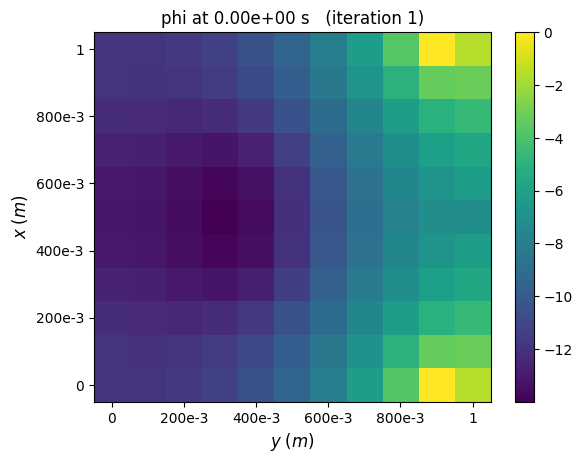

In [10]:
ts.get_field("phi", iteration=1, plot=true);

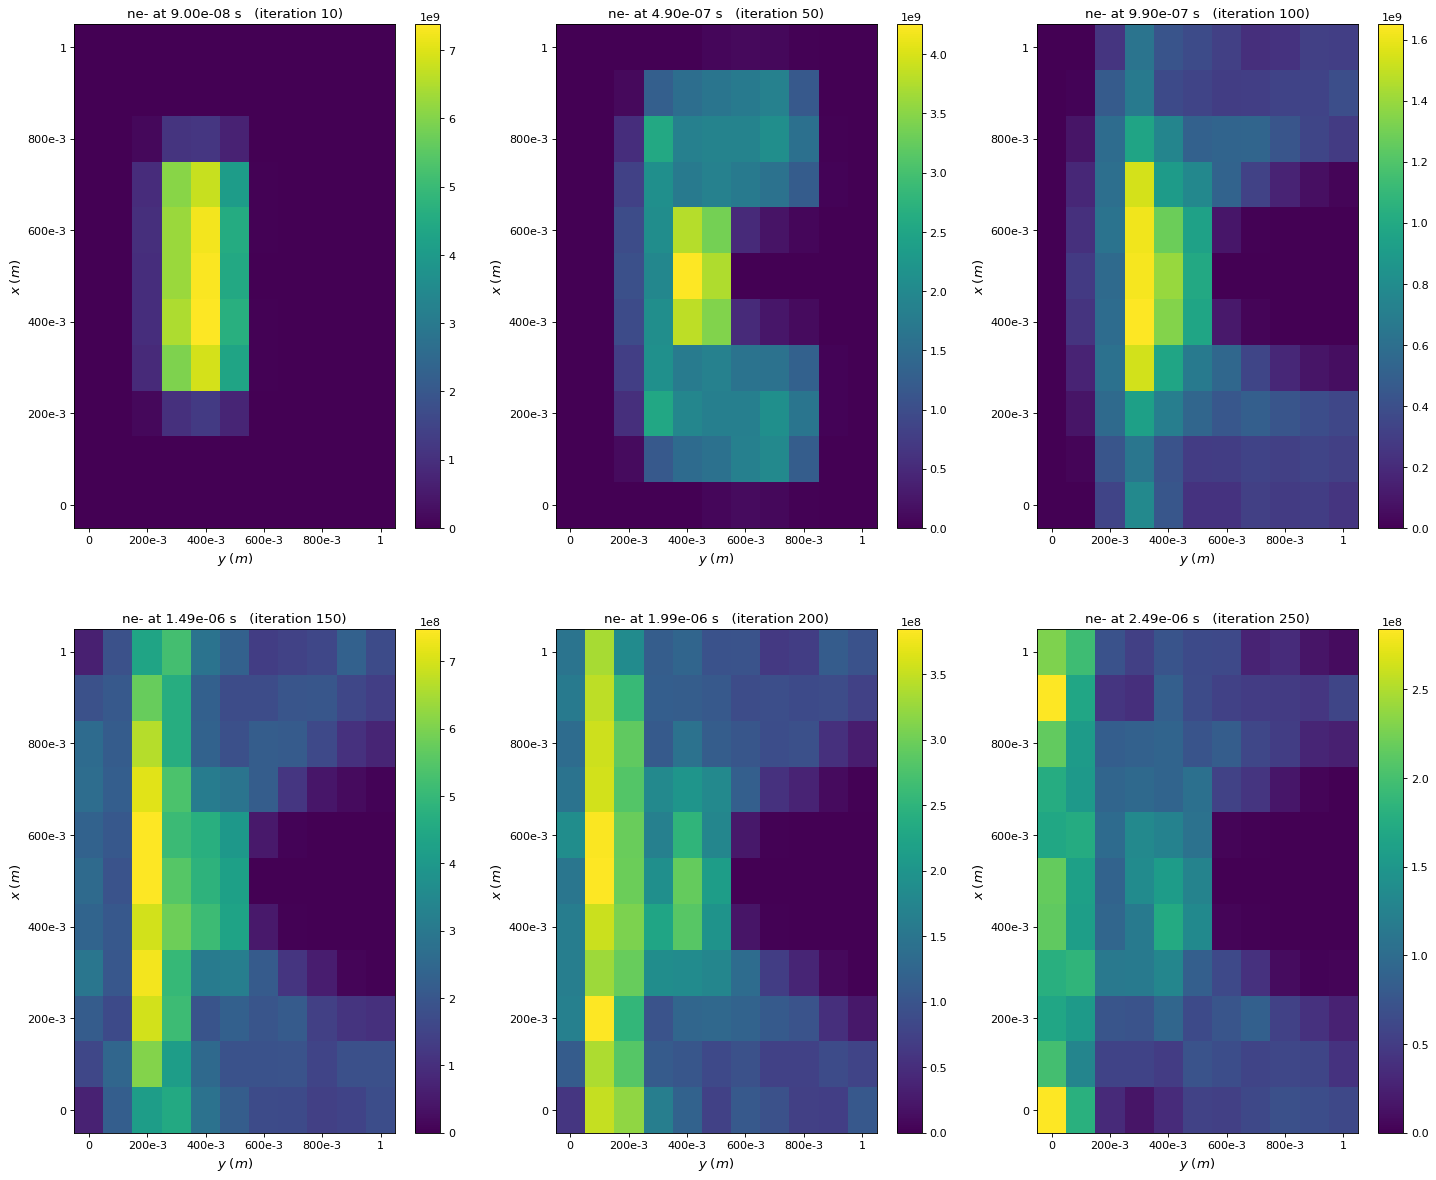

In [11]:
fig = plt.figure(figsize=(22, 18), dpi=80, facecolor="w", edgecolor="k")

plt.subplot(2, 3, 1); ts.get_field("ne-", iteration=10,  plot=true);
plt.subplot(2, 3, 2); ts.get_field("ne-", iteration=50,  plot=true);
plt.subplot(2, 3, 3); ts.get_field("ne-", iteration=100, plot=true);
plt.subplot(2, 3, 4); ts.get_field("ne-", iteration=150, plot=true);
plt.subplot(2, 3, 5); ts.get_field("ne-", iteration=200, plot=true);
plt.subplot(2, 3, 6); ts.get_field("ne-", iteration=250, plot=true);